<a href="https://colab.research.google.com/github/navneetkrc/captcha_break/blob/master/real_captchas2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import dependencies

In [0]:
from fastai.vision import *

You can get this file from this [gdrive](https://drive.google.com/file/d/1bc1_KCD2gDoUjGU0obxIRhvk2gkLL1Oc/view?usp=sharing) link.




In [2]:
#to download directly from gdrive
#!pip install gdown
!gdown https://drive.google.com/uc?id=16YJddLpAU6SZcUkSA3EZQmtIIK4X86dm

Downloading...
From: https://drive.google.com/uc?id=16YJddLpAU6SZcUkSA3EZQmtIIK4X86dm
To: /content/captchas_new.zip
3.35MB [00:00, 106MB/s]


In [3]:
!unzip '/content/captchas_new.zip'

Archive:  /content/captchas_new.zip
replace captchas/ba11e7d.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
import os
path = Path(r'/content/captchas/')
len(os.listdir(path))

1312

# Proof of concept: How many characters are there?

In [0]:
def label_from_path(p):
    return (len(p.name)-4)

In [0]:
data = (ImageList.from_folder(path)
       .split_by_rand_pct(0.2)
        .label_from_func(label_from_path, label_cls = FloatList)
        .transform([[], []], size=(40,150))
       .databunch(bs=64))#.transform([[], []], size=))

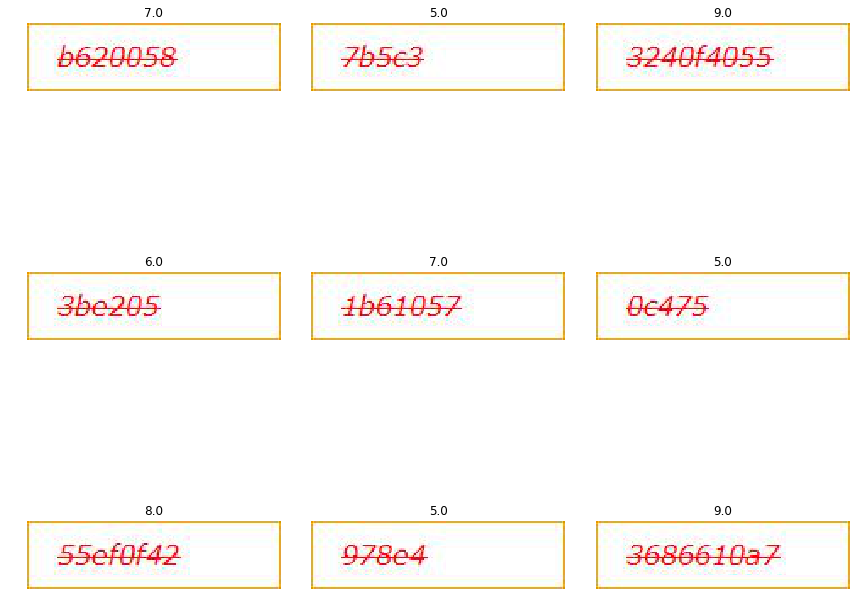

In [7]:
data.show_batch(3)

In [8]:
learn = cnn_learner(data, models.resnet18, model_dir='/temp', loss_func=nn.MSELoss())

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 98940794.08it/s]


In [0]:
learn.model.add_module('flatten', Lambda(lambda x: x.squeeze(-1)))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


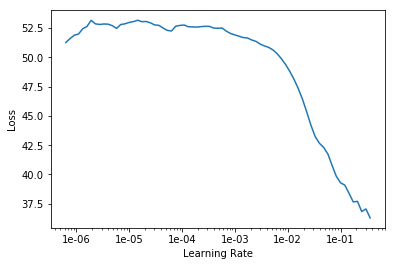

In [10]:
lr_find(learn)
learn.recorder.plot()

In [11]:
lr = 5e-2
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,time
0,29.631229,44.174381,00:02
1,14.287992,1.190487,00:01
2,8.384161,0.205087,00:01
3,5.443882,0.174919,00:01


In [0]:
learn.unfreeze()
#lr_find(learn)
#learn.recorder.plot()

In [13]:
learn.fit_one_cycle(5, slice(1e-4, lr/10))

epoch,train_loss,valid_loss,time
0,0.622503,0.232301,00:02
1,0.601699,0.277001,00:02
2,0.555475,0.069102,00:02
3,0.509092,0.075963,00:02
4,0.469847,0.053709,00:02


## Testing a random captcha

### Actual

6.0


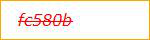

In [14]:
img,lbl = data.valid_dl.dataset[5]
print(lbl)
img

### Prediction

In [15]:
learn.predict(img)[0]

FloatItem 6.0409794

In [0]:
#learn

In [0]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_top_losses(9, figsize=(10,8)) # Prediction/ Actual/ Loss/ Probability

# Actual task

In [0]:
def unique_and_size(path):
    filenames = os.listdir(Path(r'/content/captchas/'))
    unique_chars = set()

    max_length = 0

    for filename in path.glob('*.jpg'):
        length = len(filename.name)-4

        if length>max_length: max_length=length

        chars = set(filename.name[:-4])
        if '(' in chars: continue
        unique_chars = unique_chars.union(chars)
    unique_chars.add('/')
    return unique_chars, max_length

In [0]:
unique_chars, max_length = unique_and_size(Path(r'/content/captchas/'))
chars_dimension = len(unique_chars)

encoding_dict = {l:e for e,l in enumerate(unique_chars)}
decoding_dict = {e:l for l,e in encoding_dict.items()}

def to_onehot(filename):
    code = filename.name[:-4]
    #padding
    code_len = len(code)
    code = code + '/'*(max_length-code_len)
    
    onehot = np.zeros((chars_dimension, max_length))
    for column, letter in enumerate(code):
        onehot[encoding_dict[letter], column] = 1
    return onehot.reshape(-1)

def decode(onehot):
    onehot = onehot.reshape(chars_dimension, max_length)
    idx = np.argmax(onehot, axis=0)
    return [decoding_dict[i.item()] for i in idx]

def label_accuracy(preds, actuals):
    pred = torch.unbind(preds)
    act = torch.unbind(actuals)
    
    valid = 0
    total = 0
    
    for left,right in zip(pred,act):
        total+=1
        p = decode(left)
        a = decode(right)
        if p==a: valid += 1

    return torch.tensor(valid/total)

def char_accuracy(n):
    def c_acc(preds, actuals):
        pred = torch.unbind(preds)
        act = torch.unbind(actuals)

        valid = 0
        total = 0

        for left,right in zip(pred,act):
            total+=1
            p = decode(left)
            a = decode(right)
            if p[n]==a[n]: valid += 1

        return torch.tensor(valid/total).cuda()
    return c_acc

In [20]:
unique_chars, max_length = unique_and_size(Path(r'/content/captchas/'))
chars_dimension = len(unique_chars)


encoding_dict = {l:e for e,l in enumerate(unique_chars)}
decoding_dict = {e:l for l,e in encoding_dict.items()}

print(unique_chars,max_length,chars_dimension)
print(encoding_dict)



{'5', 'c', '1', '6', 'o', 'e', '8', '/', '9', 's', '2', 'a', '7', '3', 'd', '4', 'b', 'f', '0'} 9 19
{'5': 0, 'c': 1, '1': 2, '6': 3, 'o': 4, 'e': 5, '8': 6, '/': 7, '9': 8, 's': 9, '2': 10, 'a': 11, '7': 12, '3': 13, 'd': 14, '4': 15, 'b': 16, 'f': 17, '0': 18}


In [21]:
filenames = os.listdir(Path(r'/content/captchas/'))
print(Path(r'/content/captchas/' +str(filenames[0]) +str('/')))
#os.listdir(Path(r'/content/captchas/'))

/content/captchas/a70e90.jpg


In [22]:
one_hot = to_onehot(Path(filenames[0]))
decode(one_hot), filenames[0]

(['a', '7', '0', 'e', '9', '0', '/', '/', '/'], 'a70e90.jpg')

In [0]:
data = (ImageList.from_folder(path)
        .filter_by_func(lambda x: '(' not in x.name)
        .split_by_rand_pct(0.2)
        .label_from_func(to_onehot, label_cls = FloatList)
        #.transform(get_transforms(do_flip=False))
        .transform([[], []], size=(40,150))
        .databunch()
        .normalize()
       )

In [24]:
accs = [char_accuracy(ni) for ni in range(max_length)]
learn = cnn_learner(data, models.resnet50, model_dir='/temp', loss_func=nn.MSELoss(),
                    metrics=[label_accuracy]+accs,
                   ps=0.)
#learn.model.add_module('flatten', Lambda(lambda x: x.squeeze(-1)))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 112315914.32it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


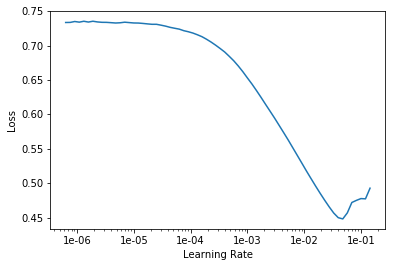

In [25]:
lr_find(learn)
learn.recorder.plot()

In [26]:
lr = 1e-2
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,label_accuracy,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,time
0,0.459165,0.236456,0.000000,0.083969,0.041985,0.057252,0.068702,0.045802,0.064885,0.095420,0.106870,0.053435,00:07
1,0.254159,0.167059,0.000000,0.167939,0.076336,0.095420,0.080153,0.122137,0.312977,0.480916,0.583969,0.748092,00:05
2,0.165821,0.061573,0.000000,0.148855,0.087786,0.095420,0.099237,0.259542,0.332061,0.488550,0.652672,0.805344,00:05
3,0.122198,0.048552,0.000000,0.129771,0.103053,0.064885,0.114504,0.213740,0.316794,0.564885,0.660305,0.809160,00:05
4,0.096267,0.046197,0.000000,0.293893,0.106870,0.095420,0.125954,0.274809,0.335878,0.553435,0.645038,0.816794,00:05
5,0.078951,0.042622,0.000000,0.286260,0.152672,0.122137,0.110687,0.282443,0.320611,0.622137,0.652672,0.809160,00:05
6,0.066309,0.040304,0.003817,0.358779,0.141221,0.171756,0.129771,0.339695,0.358779,0.625954,0.683206,0.812977,00:05
7,0.057177,0.039055,0.003817,0.438931,0.167939,0.145038,0.129771,0.354962,0.377863,0.610687,0.683206,0.809160,00:05
8,0.050288,0.038455,0.000000,0.442748,0.171756,0.175573,0.145038,0.316794,0.351145,0.625954,0.675573,0.812977,00:05
9,0.045089,0.037995,0.003817,0.458015,0.183206,0.179389,0.133588,0.335878,0.374046,0.625954,0.671756,0.816794,00:05


In [0]:
learn.unfreeze()
#lr_find(learn)
#learn.recorder.plot()

In [28]:
#set to 80 the fit one cycle
learn.fit_one_cycle(80, slice(1e-3, 1e-4))

epoch,train_loss,valid_loss,label_accuracy,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,time
0,0.032173,0.037834,0.000000,0.530534,0.187023,0.179389,0.133588,0.362595,0.377863,0.618321,0.675573,0.816794,00:08
1,0.031661,0.038181,0.000000,0.572519,0.183206,0.156489,0.148855,0.332061,0.362595,0.618321,0.679389,0.824427,00:06
2,0.030956,0.037065,0.000000,0.622137,0.255725,0.175573,0.152672,0.343511,0.396947,0.622137,0.679389,0.816794,00:06
3,0.030266,0.037325,0.000000,0.633588,0.255725,0.179389,0.175573,0.370229,0.362595,0.610687,0.671756,0.832061,00:06
4,0.029625,0.036992,0.003817,0.690840,0.251908,0.187023,0.160305,0.377863,0.389313,0.629771,0.694656,0.839695,00:06
5,0.028974,0.036901,0.003817,0.698473,0.320611,0.187023,0.202290,0.351145,0.374046,0.618321,0.694656,0.832061,00:06
6,0.028426,0.037063,0.000000,0.763359,0.301527,0.221374,0.206107,0.358779,0.396947,0.648855,0.709924,0.862595,00:06
7,0.027836,0.036905,0.003817,0.736641,0.332061,0.221374,0.198473,0.377863,0.385496,0.645038,0.721374,0.847328,00:06
8,0.027341,0.037568,0.000000,0.778626,0.290076,0.206107,0.194656,0.362595,0.362595,0.656489,0.706107,0.851145,00:06
9,0.026867,0.036395,0.003817,0.847328,0.328244,0.229008,0.225191,0.381679,0.381679,0.660305,0.709924,0.862595,00:06


In [0]:
img, lbl = data.valid_dl.dataset[0]

In [30]:
pred = learn.predict(img)[0]
decode(torch.tensor(pred.data))

['f', '1', 'c', '0', '0', '0', '/', '/', '/']

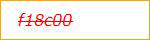

In [31]:
img

# Cross Entropy

In [0]:
def multi_cross_entropy(inp, target):
    re_inp = inp.view(-1, max_length, chars_dimension)
    re_target = target.view(-1, max_length, chars_dimension)
    soft = F.log_softmax(re_inp, dim=0)
    cross = soft*re_target
    return -cross.mean()

In [0]:
accs = [char_accuracy(ni) for ni in range(max_length)]
learn = cnn_learner(data, models.resnet50, model_dir='/temp', loss_func=multi_cross_entropy,
                    metrics=[label_accuracy]+accs,
                   ps=0.1)
#learn.model.add_module('flatten', Lambda(lambda x: x.squeeze(-1)))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


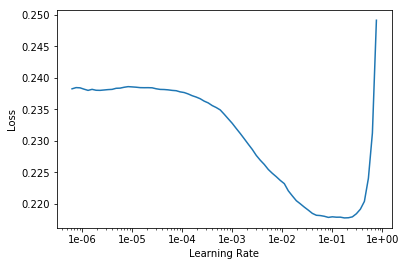

In [35]:
lr_find(learn)
learn.recorder.plot()

In [36]:
lr = 5e-2
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,label_accuracy,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,time
0,0.222904,0.227602,0.000000,0.061069,0.049618,0.083969,0.087786,0.041985,0.114504,0.026718,0.022901,0.007634,00:05
1,0.211534,0.214168,0.000000,0.099237,0.049618,0.095420,0.076336,0.064885,0.041985,0.103053,0.015267,0.011450,00:05
2,0.201527,0.198936,0.000000,0.122137,0.099237,0.103053,0.118321,0.068702,0.091603,0.152672,0.061069,0.011450,00:05
3,0.191459,0.186333,0.000000,0.244275,0.114504,0.225191,0.164122,0.080153,0.118321,0.209924,0.251908,0.041985,00:05
4,0.182758,0.185359,0.000000,0.293893,0.286260,0.236641,0.206107,0.091603,0.263359,0.446565,0.278626,0.061069,00:05
5,0.174597,0.175614,0.000000,0.442748,0.244275,0.236641,0.190840,0.091603,0.270992,0.553435,0.312977,0.007634,00:05
6,0.166338,0.165368,0.000000,0.572519,0.492366,0.492366,0.412214,0.225191,0.370229,0.488550,0.427481,0.068702,00:05
7,0.157517,0.159951,0.000000,0.687023,0.610687,0.603053,0.576336,0.270992,0.423664,0.496183,0.320611,0.057252,00:05
8,0.149278,0.155994,0.000000,0.812977,0.732824,0.629771,0.618321,0.240458,0.465649,0.580153,0.385496,0.057252,00:05
9,0.142234,0.155072,0.000000,0.828244,0.759542,0.671756,0.625954,0.263359,0.473282,0.629771,0.404580,0.053435,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


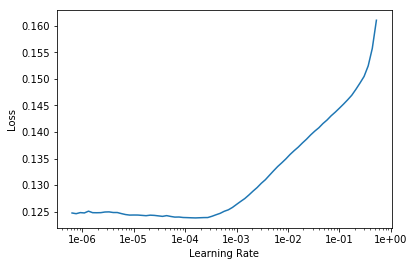

In [37]:
learn.unfreeze()
lr_find(learn)
learn.recorder.plot()

In [38]:
#fit one cycle 60
learn.fit_one_cycle(60, slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,label_accuracy,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,time
0,0.132275,0.159969,0.000000,0.541985,0.603053,0.488550,0.469466,0.221374,0.438931,0.645038,0.557252,0.045802,00:06
1,0.130184,0.155884,0.000000,0.568702,0.625954,0.557252,0.538168,0.282443,0.469466,0.614504,0.419847,0.034351,00:06
2,0.128235,0.153638,0.000000,0.450382,0.694656,0.549618,0.564885,0.297710,0.450382,0.572519,0.454198,0.053435,00:06
3,0.126933,0.151605,0.000000,0.599237,0.595420,0.583969,0.591603,0.274809,0.488550,0.614504,0.500000,0.034351,00:06
4,0.126505,0.153138,0.000000,0.503817,0.557252,0.396947,0.561069,0.293893,0.507634,0.637405,0.412214,0.164122,00:06
5,0.126551,0.158541,0.000000,0.217557,0.450382,0.454198,0.477099,0.217557,0.557252,0.675573,0.427481,0.030534,00:06
6,0.126939,0.155897,0.000000,0.118321,0.553435,0.324427,0.347328,0.217557,0.488550,0.416031,0.332061,0.049618,00:06
7,0.126865,0.152893,0.000000,0.396947,0.458015,0.320611,0.438931,0.267176,0.519084,0.721374,0.583969,0.064885,00:06
8,0.126636,0.152065,0.000000,0.358779,0.507634,0.362595,0.557252,0.381679,0.438931,0.591603,0.316794,0.041985,00:06
9,0.126512,0.153571,0.000000,0.286260,0.534351,0.507634,0.446565,0.354962,0.408397,0.671756,0.591603,0.118321,00:06


# Single Char

In [0]:
def label_from_path(position, filename):
    label = filename.name[:-4]
    label = label + '/'*(max_length-len(label))
    return label[position]

In [0]:
from functools import partial
data = (ImageList.from_folder(path)
       .split_by_rand_pct(0.2)
        .label_from_func(partial(label_from_path, -1))
        .transform([[], []], size=(40,150))
       .databunch(bs=64))#.transform([[], []], size=))

In [0]:
learn = cnn_learner(data, models.resnet50, model_dir='/temp',
                    metrics=accuracy, ps=0.2)
#learn.model.add_module('flatten', Lambda(lambda x: x.squeeze(-1)))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


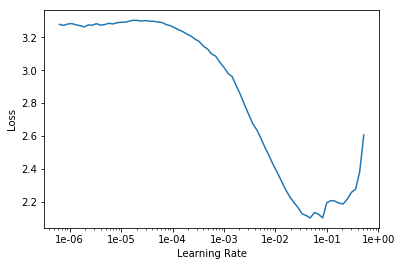

In [43]:
lr_find(learn)
learn.recorder.plot()

In [44]:
lr = 1e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.866380,1.298362,0.736641,00:03
1,1.118608,1.381747,0.732824,00:03
2,0.791408,0.716328,0.851145,00:03
3,0.563610,0.276880,0.935115,00:03
4,0.388960,0.130028,0.961832,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


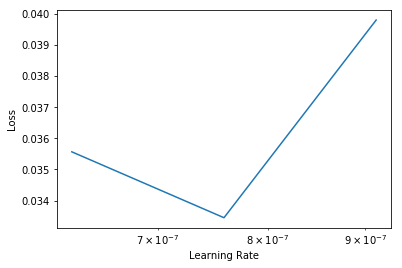

In [45]:
learn.unfreeze()
lr_find(learn)
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(20, slice(1e-4, lr/10))

epoch,train_loss,valid_loss,accuracy,time
0,0.057073,0.118634,0.969466,00:05
1,0.052486,0.171177,0.946565,00:05
2,0.051407,1.363875,0.835878,00:05
3,0.082180,1.259846,0.835878,00:05
4,0.127736,1.558593,0.805344,00:05
5,0.119385,0.387900,0.912214,00:05
6,0.125718,0.253178,0.919847,00:05
7,0.113992,0.202371,0.942748,00:05
8,0.104525,0.156160,0.969466,00:05
9,0.086764,0.103690,0.969466,00:05


In [0]:
import copy
learners = []

In [48]:
for i in range(max_length):
    data = (ImageList.from_folder(path)
       .split_by_rand_pct(0.2)
        .label_from_func(partial(label_from_path, i))
        .transform([[], []], size=(40,150))
       .databunch(bs=64))
    
    print(i)
    learn = cnn_learner(data, models.resnet50, model_dir='/temp',
                    metrics=accuracy)
    
    lr = 1e-2
    learn.fit_one_cycle(5, lr)
    
    learn.unfreeze()
    learn.fit_one_cycle(20, slice(1e-4, lr/10))
    learners.append(copy.deepcopy(learn))

0


epoch,train_loss,valid_loss,accuracy,time
0,2.345468,4.322723,0.141221,00:03
1,1.134213,4.230481,0.225191,00:03
2,0.659948,1.221373,0.618321,00:03
3,0.421973,0.015802,1.000000,00:03
4,0.283060,0.007367,1.000000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.022426,0.003579,1.000000,00:05
1,0.023770,0.023325,0.996183,00:05
2,0.026931,0.031662,0.992366,00:05
3,0.029548,1.003388,0.748092,00:05
4,0.110403,1.202940,0.824427,00:05
5,0.102415,0.075279,0.977099,00:05
6,0.111611,0.429633,0.916031,00:05
7,0.113326,1.429153,0.793893,00:05
8,0.091945,0.010861,0.996183,00:05
9,0.070757,0.000889,1.000000,00:05


1


epoch,train_loss,valid_loss,accuracy,time
0,3.100902,4.119976,0.087786,00:04
1,2.603589,3.816440,0.175573,00:03
2,1.871744,1.339110,0.595420,00:03
3,1.272491,0.408319,0.870229,00:03
4,0.877741,0.229841,0.935115,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.100974,0.180062,0.954198,00:05
1,0.072956,0.138624,0.954198,00:05
2,0.058560,0.116879,0.969466,00:05
3,0.081805,0.819311,0.809160,00:05
4,0.103887,1.277019,0.744275,00:05
5,0.101052,0.243493,0.935115,00:05
6,0.091226,0.191122,0.946565,00:05
7,0.074732,0.052380,0.988550,00:05
8,0.058190,0.066709,0.980916,00:05
9,0.046293,0.028401,0.992366,00:05


2


epoch,train_loss,valid_loss,accuracy,time
0,3.073113,4.610571,0.068702,00:03
1,2.586293,3.980541,0.183206,00:03
2,1.987661,1.821144,0.454198,00:03
3,1.425472,0.808039,0.725191,00:03
4,1.020323,0.667356,0.812977,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.226141,0.584279,0.847328,00:05
1,0.152402,0.483531,0.862595,00:05
2,0.113751,0.594115,0.828244,00:05
3,0.106344,0.574572,0.809160,00:05
4,0.141231,0.859484,0.782443,00:05
5,0.145683,0.884409,0.748092,00:05
6,0.142126,0.523444,0.862595,00:05
7,0.118108,0.281011,0.931298,00:05
8,0.097782,0.142868,0.950382,00:05
9,0.081840,0.220539,0.942748,00:05


3


epoch,train_loss,valid_loss,accuracy,time
0,3.252683,3.966469,0.068702,00:03
1,2.806268,4.829422,0.099237,00:03
2,2.203381,2.348898,0.347328,00:03
3,1.622695,0.952962,0.713740,00:03
4,1.178319,0.717540,0.786260,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.305022,0.612495,0.824427,00:05
1,0.204097,0.593510,0.828244,00:05
2,0.153934,0.473361,0.851145,00:05
3,0.145915,0.759565,0.778626,00:05
4,0.171723,0.655531,0.820611,00:05
5,0.184222,0.459356,0.885496,00:05
6,0.155609,0.216581,0.919847,00:05
7,0.120121,0.109200,0.965649,00:05
8,0.090869,0.118038,0.958015,00:05
9,0.073085,0.058383,0.984733,00:05


4


epoch,train_loss,valid_loss,accuracy,time
0,3.232610,5.790541,0.061069,00:03
1,2.846843,3.388904,0.183206,00:03
2,2.514123,2.588368,0.286260,00:03
3,2.105663,1.961768,0.412214,00:03
4,1.722433,1.789878,0.442748,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.905534,1.691282,0.465649,00:05
1,0.682693,1.551204,0.511450,00:05
2,0.523349,1.613666,0.545802,00:05
3,0.441017,1.719805,0.534351,00:05
4,0.480439,1.926288,0.503817,00:05
5,0.473173,1.463610,0.622137,00:05
6,0.403316,1.002670,0.759542,00:05
7,0.316847,0.718467,0.828244,00:05
8,0.247465,0.627928,0.835878,00:05
9,0.187628,0.563613,0.866412,00:05


5


epoch,train_loss,valid_loss,accuracy,time
0,2.710780,4.281850,0.095420,00:04
1,2.316512,3.002886,0.041985,00:03
2,2.026604,3.175100,0.225191,00:03
3,1.688992,1.652839,0.503817,00:03
4,1.343355,1.291804,0.622137,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.644899,1.264387,0.645038,00:05
1,0.476162,1.248175,0.622137,00:05
2,0.363510,1.263749,0.614504,00:05
3,0.306664,1.517890,0.606870,00:05
4,0.370728,1.452331,0.595420,00:05
5,0.387293,0.969352,0.755725,00:05
6,0.329028,0.665761,0.832061,00:05
7,0.258962,0.417272,0.881679,00:05
8,0.197372,0.364092,0.908397,00:05
9,0.150432,0.379221,0.874046,00:05


6


epoch,train_loss,valid_loss,accuracy,time
0,2.188117,3.301815,0.408397,00:03
1,1.778308,2.839214,0.244275,00:03
2,1.478018,2.249568,0.370229,00:03
3,1.180054,1.246871,0.667939,00:04
4,0.911374,1.007436,0.698473,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.364634,0.886740,0.732824,00:05
1,0.272636,1.023162,0.725191,00:05
2,0.215913,0.861696,0.793893,00:05
3,0.212748,0.967825,0.732824,00:05
4,0.282370,1.423054,0.595420,00:05
5,0.271171,0.547431,0.862595,00:05
6,0.229367,0.486017,0.870229,00:05
7,0.190291,0.439462,0.866412,00:05
8,0.161348,0.452587,0.889313,00:05
9,0.131257,0.473842,0.870229,00:05


7


epoch,train_loss,valid_loss,accuracy,time
0,1.943670,2.089771,0.622137,00:03
1,1.469556,1.892904,0.622137,00:03
2,1.159208,1.009528,0.748092,00:03
3,0.883061,0.822228,0.809160,00:03
4,0.655902,0.694138,0.828244,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.199871,0.671319,0.851145,00:05
1,0.142657,0.638915,0.854962,00:05
2,0.117683,0.804453,0.805344,00:05
3,0.158602,0.809316,0.835878,00:05
4,0.221666,1.451133,0.729008,00:05
5,0.224091,0.716334,0.828244,00:05
6,0.205122,0.570782,0.862595,00:05
7,0.171360,0.616751,0.889313,00:05
8,0.140302,0.508135,0.889313,00:05
9,0.111070,0.384671,0.927481,00:05


8


epoch,train_loss,valid_loss,accuracy,time
0,2.145243,3.752228,0.083969,00:04
1,1.273200,1.230376,0.774809,00:03
2,0.879899,1.207015,0.778626,00:03
3,0.616359,0.503548,0.877863,00:03
4,0.434367,0.146533,0.958015,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.089306,0.141247,0.965649,00:05
1,0.070802,0.127948,0.965649,00:05
2,0.073907,0.246551,0.935115,00:05
3,0.104174,0.291635,0.938931,00:05
4,0.132323,0.798132,0.851145,00:05
5,0.173320,1.424944,0.702290,00:05
6,0.170999,0.162586,0.954198,00:05
7,0.136134,0.095598,0.988550,00:05
8,0.099653,0.086375,0.988550,00:05
9,0.078777,0.097147,0.988550,00:05


In [0]:
def predict_captcha(img, learners):
    return ''.join([str(learner.predict(img)[0]) for learner in learners])

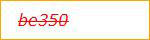

In [50]:
img, lbl = data.valid_dl.dataset[0]
img

In [51]:
predict_captcha(img, learners)

'be350////'

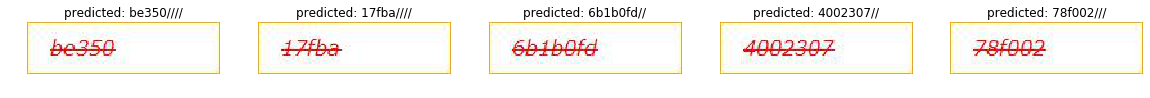

In [52]:
fig, ax = plt.subplots(ncols=5, figsize=(20,10))
for a, (img, lbl) in zip(ax.flatten(), learners[0].data.valid_ds):
    show_image(img, a)
    a.set_title(f'predicted: {predict_captcha(img, learners)}')
plt.show()

In [53]:
img_paths = learners[0].data.valid_ds.items
count = 0
correct = 0

for img_path in img_paths:
    lbl = img_path.name[:-4]
    
    code_len = len(lbl)
    lbl = lbl + '/'*(max_length-code_len)
    
    img = open_image(img_path)
    predicted = predict_captcha(img, learners)
    if lbl==predicted: correct +=1
    count += 1
correct/count

0.9312977099236641

##Interpretation of different learners
This was mainly used to check for mislabeling of the dataset 
Before the removal or correction of labels the accuracy was around 93% expacting a lot of improvement once this is sorted out.

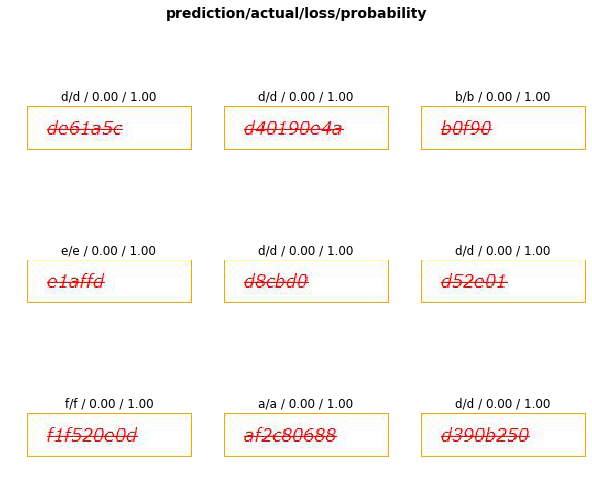

In [54]:
interp = ClassificationInterpretation.from_learner(learners[0])
interp.plot_top_losses(9, figsize=(10,8)) # Prediction/ Actual/ Loss/ Probability

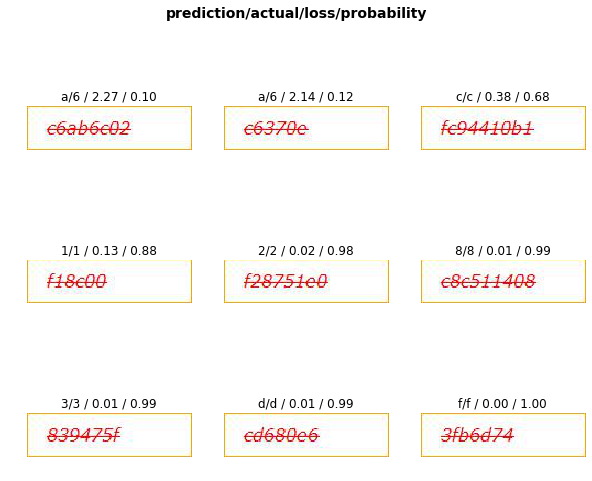

In [55]:
interp = ClassificationInterpretation.from_learner(learners[1])
interp.plot_top_losses(9, figsize=(10,8)) # Prediction/ Actual/ Loss/ Probability

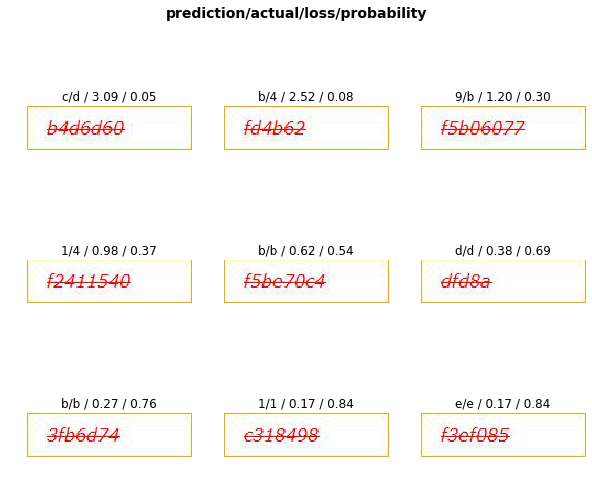

In [56]:
interp = ClassificationInterpretation.from_learner(learners[2])
interp.plot_top_losses(9, figsize=(10,8)) # Prediction/ Actual/ Loss/ Probability

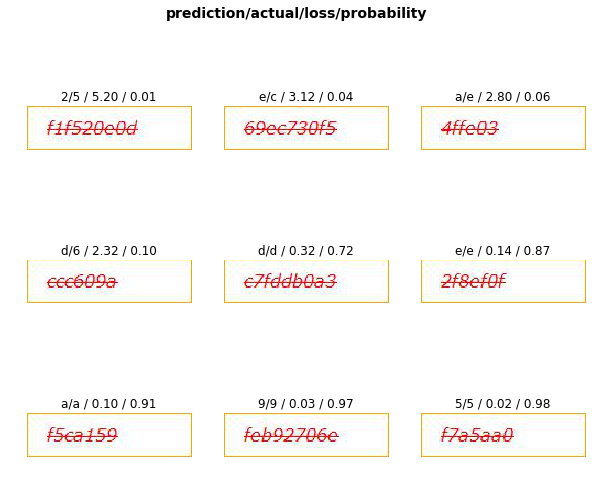

In [57]:
interp = ClassificationInterpretation.from_learner(learners[3])
interp.plot_top_losses(9, figsize=(10,8)) # Prediction/ Actual/ Loss/ Probability

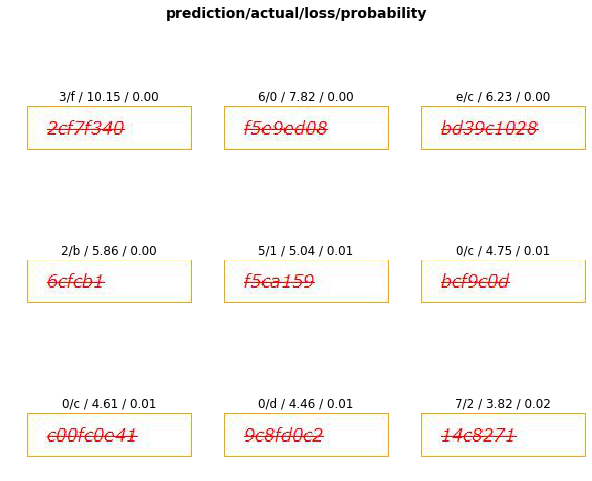

In [58]:
interp = ClassificationInterpretation.from_learner(learners[4])
interp.plot_top_losses(9, figsize=(10,8)) # Prediction/ Actual/ Loss/ Probability

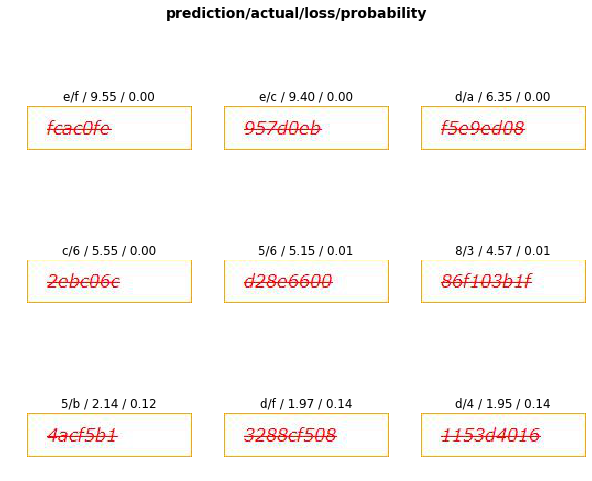

In [59]:
interp = ClassificationInterpretation.from_learner(learners[5])
interp.plot_top_losses(9, figsize=(10,8)) # Prediction/ Actual/ Loss/ Probability

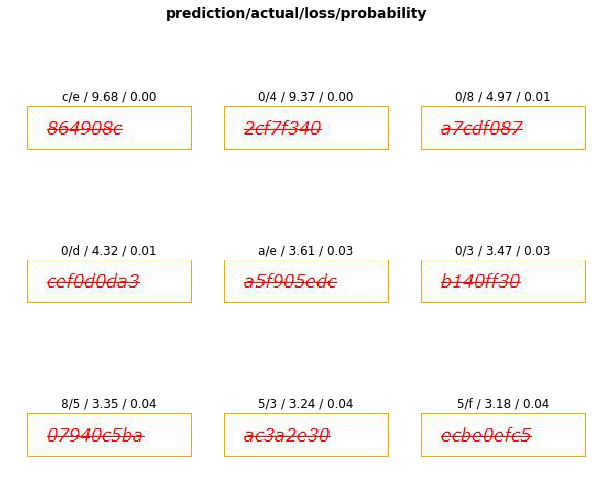

In [60]:
interp = ClassificationInterpretation.from_learner(learners[6])
interp.plot_top_losses(9, figsize=(10,8)) # Prediction/ Actual/ Loss/ Probability

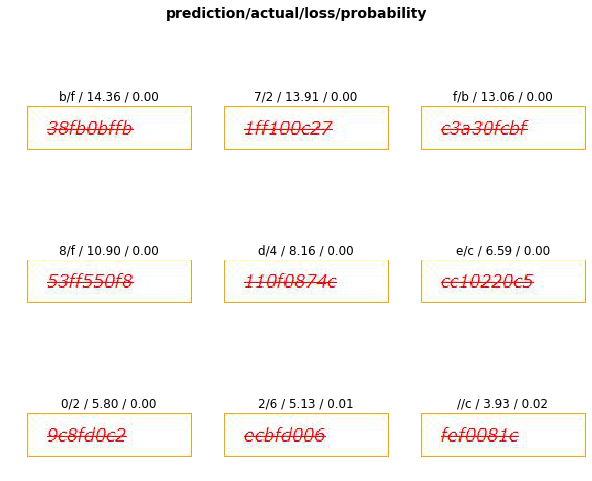

In [61]:
interp = ClassificationInterpretation.from_learner(learners[7])
interp.plot_top_losses(9, figsize=(10,8)) # Prediction/ Actual/ Loss/ Probability

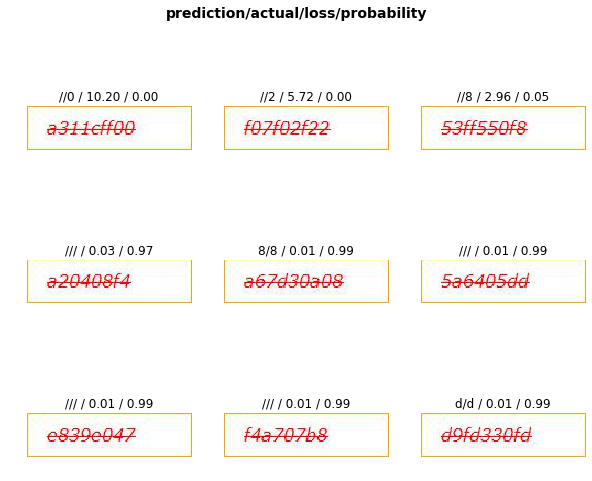

In [62]:
interp = ClassificationInterpretation.from_learner(learners[8])
interp.plot_top_losses(9, figsize=(10,8)) # Prediction/ Actual/ Loss/ Probability